In [1]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2

from rdkit import RDLogger
from utils import generator_from_conf, conf_from_yaml
RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        conf = conf_from_yaml(yaml_path, repo_root)
        generator = generator_from_conf(conf, repo_root)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/home/fujii/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BioT5 models...
Model loading completed.


seed: 1751425904
Starting generation...


<best reward updated> order: 1, time: 0.00, reward: 0.1383, node: [O][C][=C][C][=C][C][=C][Ring1][=Branch1]
<best reward updated> order: 2, time: 0.50, reward: 0.3353, node: [C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][C][=C][Ring1][=Branch1]
<best reward updated> order: 3, time: 0.50, reward: 0.3919, node: [C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1]
<best reward updated> order: 4, time: 1.41, reward: 0.4458, node: [C][O][C][=C][C][=C][C][Branch1][C][Cl][=C][Ring1][#Branch1][O][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1]
<best reward updated> order: 5, time: 2.48, reward: 0.5442, node: [C][O][C][=C][C][Branch1][C][Cl][=C][Branch1][C][Cl][C][Branch1][C][Cl][=C][Ring1][=Branch2][O][C][=C][C][=C][Branch1][C][Cl][C][=C][Ring1][#Branch1]
order: 6, time: 3.80, reward: 0.4068, node: [C][O][C][=C][Branch1][C][Cl][C][Branch1][C][Cl][=C][Branch1][C][Cl][C][Branch1][Ring1][O][C][=C][Ring1][O][Cl]
<best reward upd

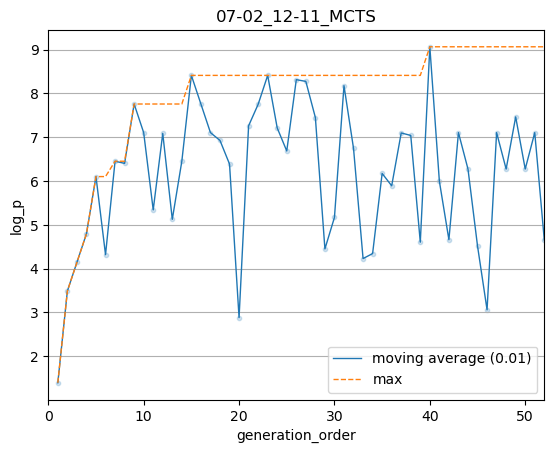

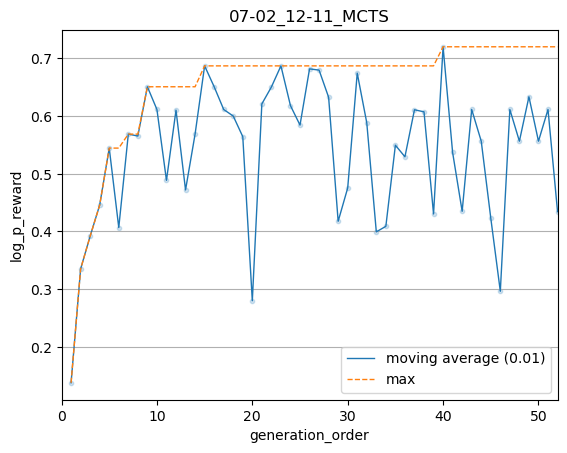

number of generated nodes: 52
valid rate: 1.0
unique rate: 0.12322274881516593
node_per_sec: 0.15146233031535106
best_reward: 0.7194529452218181
average_reward: 0.5385959697212275


In [3]:
# start generation
c1 = "config/mcts_helm.yaml"
c2 = "config/mcts_smiles.yaml"
c3 = "config/model_test.yaml"
c4 = "config/mcts_d_score.yaml"
c5 = "config/mcts_biot5.yaml"

conf = conf_from_yaml(c5, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)